In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-analytics-ue20cs312/sample_submission.csv
/kaggle/input/data-analytics-ue20cs312/train.csv
/kaggle/input/data-analytics-ue20cs312/test.csv


In [2]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
# importing required libraries
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA  
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
# importing datasets
train = pd.read_csv("/kaggle/input/data-analytics-ue20cs312/train.csv");
test = pd.read_csv("/kaggle/input/data-analytics-ue20cs312/test.csv");

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1655 entries, 0 to 1654
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1655 non-null   object 
 1   Open    1655 non-null   float64
 2   High    1655 non-null   float64
 3   Low     1655 non-null   float64
 4   Close   1655 non-null   float64
 5   Volume  1655 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 77.7+ KB


In [6]:
train.head()

,Date,Open,High,Low,Close,Volume
0,2016-01-04,1099.59,1110.75,1093.85,1109.64,66545000
1,2016-01-05,1117.47,1130.57,1112.75,1125.85,41227200
2,2016-01-06,1116.63,1138.68,1116.10,1133.04,42316800
3,2016-01-07,1122.00,1149.76,1117.56,1143.37,64899600
4,2016-01-08,1145.64,1149.96,1120.93,1122.88,52138900


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    35 non-null     object 
 1   Open    35 non-null     float64
 2   High    35 non-null     float64
 3   Low     35 non-null     float64
 4   Volume  35 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 1.5+ KB


In [8]:
# date index training dataset
train['Date'] = pd.to_datetime(train.Date)
date_indexed_train = train.drop(['Date'], axis=1)
train.index = train.Date
print(train.dtypes)
train

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object


,Date,Open,High,Low,Close,Volume
Date,,,,,,
2016-01-04,2016-01-04,1099.59,1110.75,1093.85,1109.64,66545000
2016-01-05,2016-01-05,1117.47,1130.57,1112.75,1125.85,41227200
2016-01-06,2016-01-06,1116.63,1138.68,1116.10,1133.04,42316800
2016-01-07,2016-01-07,1122.00,1149.76,1117.56,1143.37,64899600
2016-01-08,2016-01-08,1145.64,1149.96,1120.93,1122.88,52138900
...,...,...,...,...,...,...
2022-07-25,2022-07-25,2412.25,2429.44,2387.41,2402.95,29106300
2022-07-26,2022-07-26,2289.29,2307.08,2255.66,2280.27,48503400
2022-07-27,2022-07-27,2309.14,2404.25,2296.82,2395.54,43790900


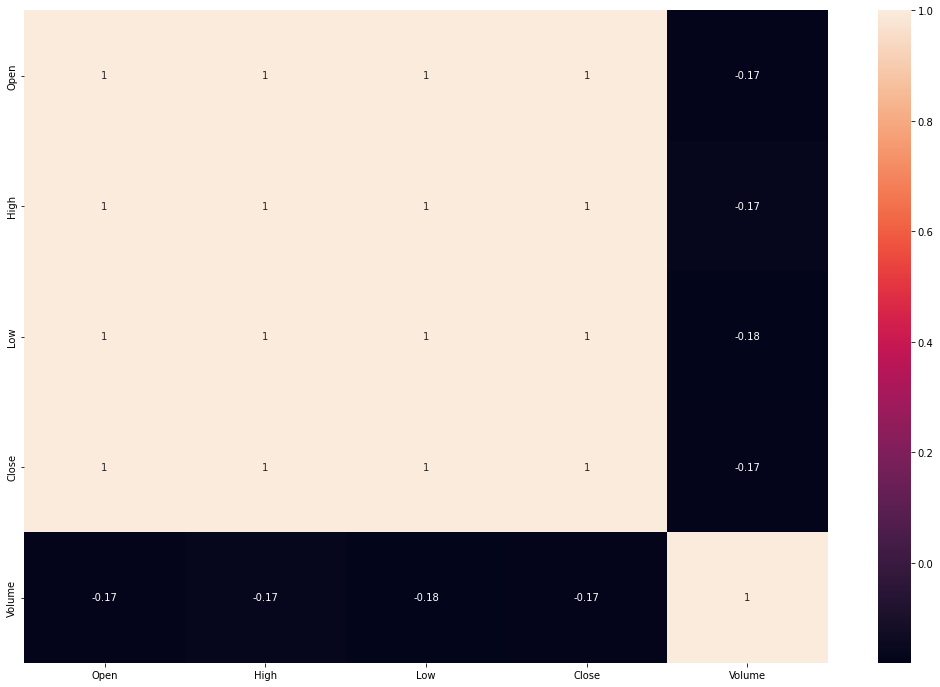

In [9]:
# correlation plot
import seaborn as sns
corr = train[1:].corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot = True);

Variables Open, High, Low and Close are strongly correlated.<br>
Correlation of Volume with the other variables is low.

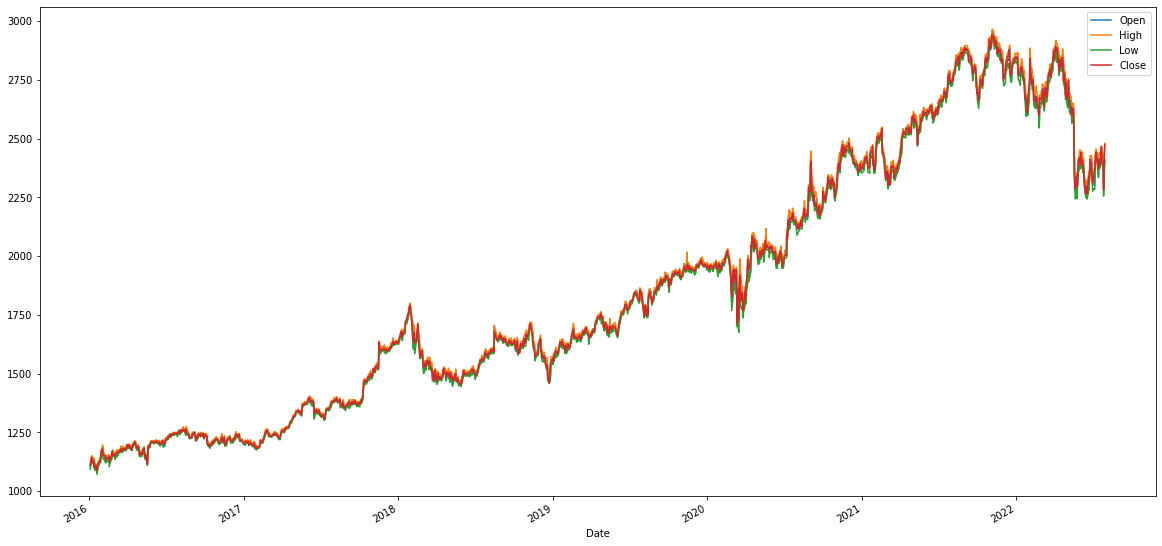

In [10]:
ax = plt.gca()
for column in train[1:5]:
    if column != 'Date' and column  != 'Volume':
        train.plot(x = 'Date', y = column, figsize=(20, 10), ax = ax)

The data has upward trend for columns Open, High, Low, and Close.

<AxesSubplot:xlabel='Date'>

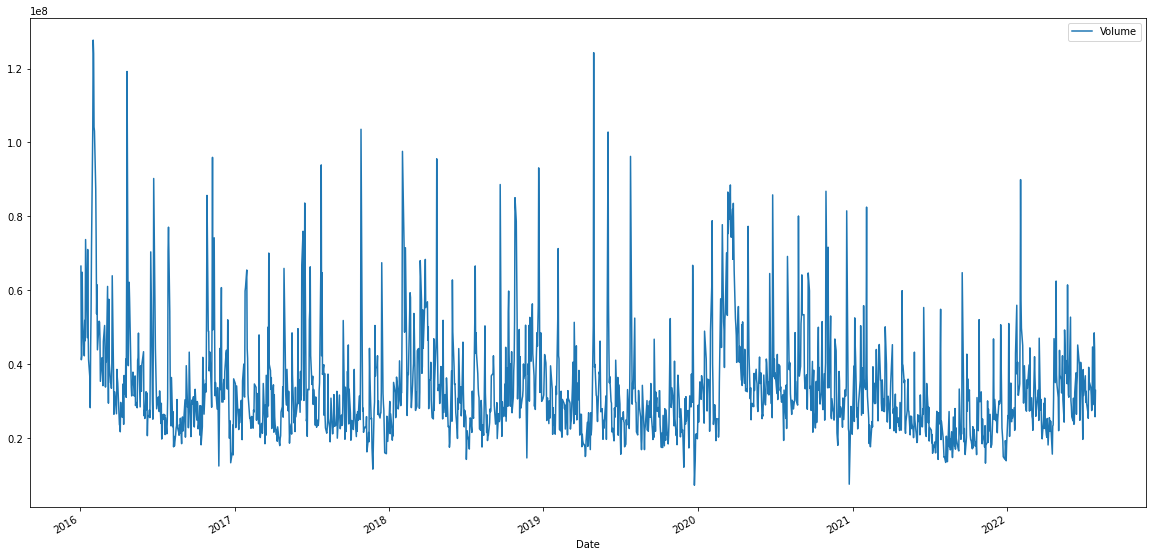

In [11]:
train.plot(x = 'Date', y = 'Volume', figsize=(20, 10))

Volume column in the data is stationary.

In [12]:
train.isna().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Dataframe has no missing values.

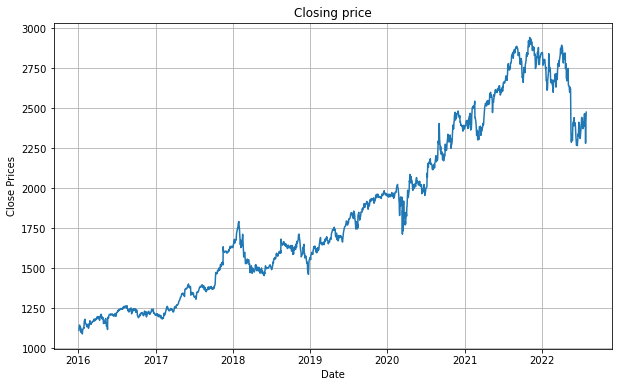

In [13]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(train['Close'])
plt.title('Closing price')
plt.show()

In [14]:
# running Augmented Dickey-Fuller test on data

def print_adf_results(col, adf_result):
    print(col, end=':\n')
    print('ADF Statistic: %f' % adf_result[0])
    print('p-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))
        
for column in train:
    if column != 'Date':
        print_adf_results(column, adfuller(train[column]))


Open:
ADF Statistic: -1.111620
p-value: 0.710416
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
High:
ADF Statistic: -0.975138
p-value: 0.762224
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Low:
ADF Statistic: -1.047055
p-value: 0.735718
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Close:
ADF Statistic: -0.961490
p-value: 0.767050
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Volume:
ADF Statistic: -7.882791
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


From the Augmented Dickey-Fuller test, the following columns are not stationary:
* Open 
* High
* Low
* Close<br>
<br>
Applying differencing to make the variables stationary:

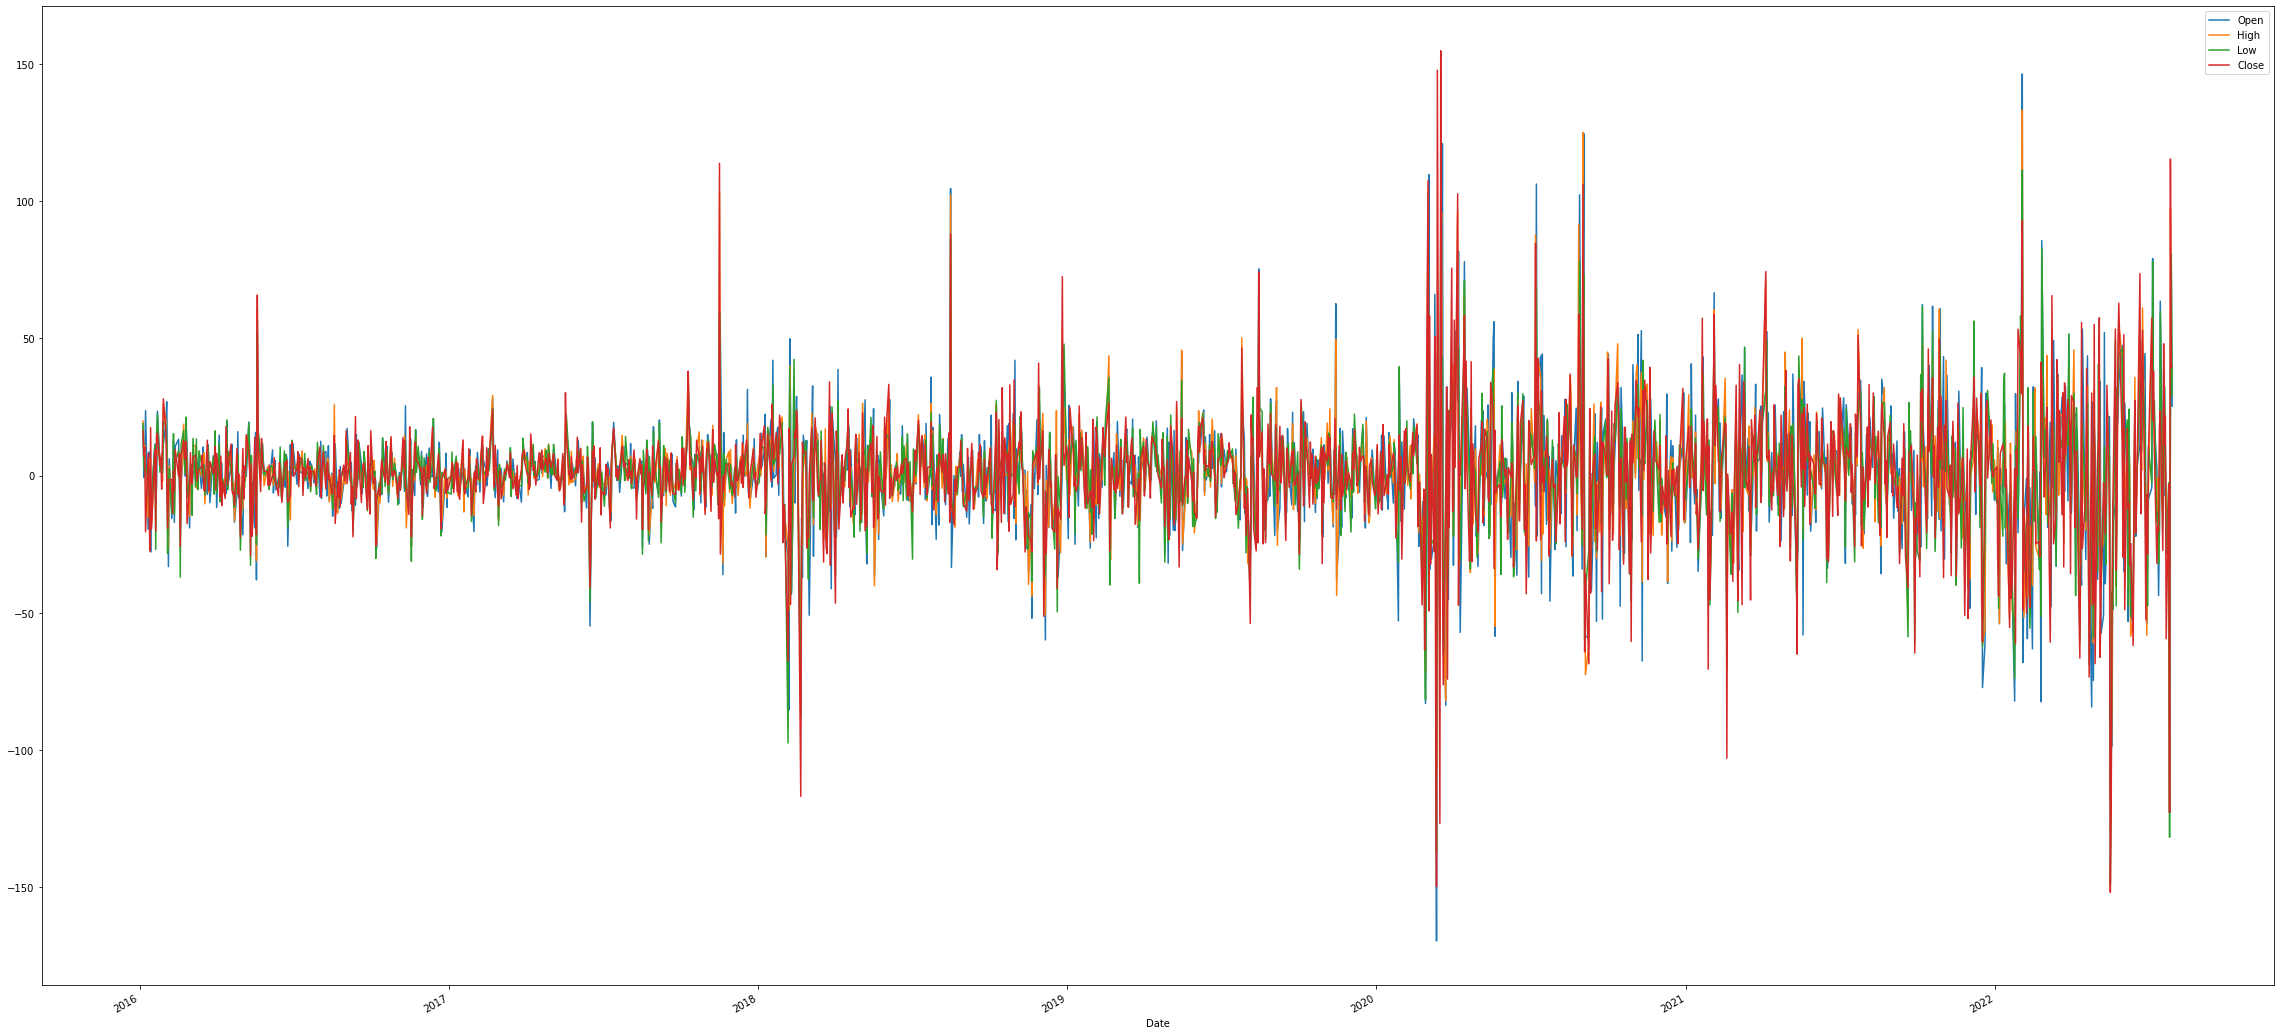

In [15]:
transformed_train = train.copy()
nax = plt.gca()
for column in transformed_train:
    if column != 'Date' and column != 'Volume':
        transformed_train[column] = train[column] - train[column].shift(1)
        transformed_train.dropna().plot(x = 'Date', y = column, figsize=(40, 20), ax = nax)

In [16]:
transformed_train.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2016-01-04,2016-01-04,NaN,NaN,NaN,NaN,66545000
2016-01-05,2016-01-05,17.88,19.82,18.90,16.21,41227200
2016-01-06,2016-01-06,-0.84,8.11,3.35,7.19,42316800
2016-01-07,2016-01-07,5.37,11.08,1.46,10.33,64899600
2016-01-08,2016-01-08,23.64,0.20,3.37,-20.49,52138900


In [17]:
transformed_train.dropna(inplace = True)
for column in transformed_train:
    if column != 'Date':
        print_adf_results(column, adfuller(train[column]))

Open:
ADF Statistic: -1.111620
p-value: 0.710416
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
High:
ADF Statistic: -0.975138
p-value: 0.762224
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Low:
ADF Statistic: -1.047055
p-value: 0.735718
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Close:
ADF Statistic: -0.961490
p-value: 0.767050
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Volume:
ADF Statistic: -7.882791
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


From Augmented Dickey-Fuller Test, all columns are stationary.

<Figure size 432x288 with 0 Axes>

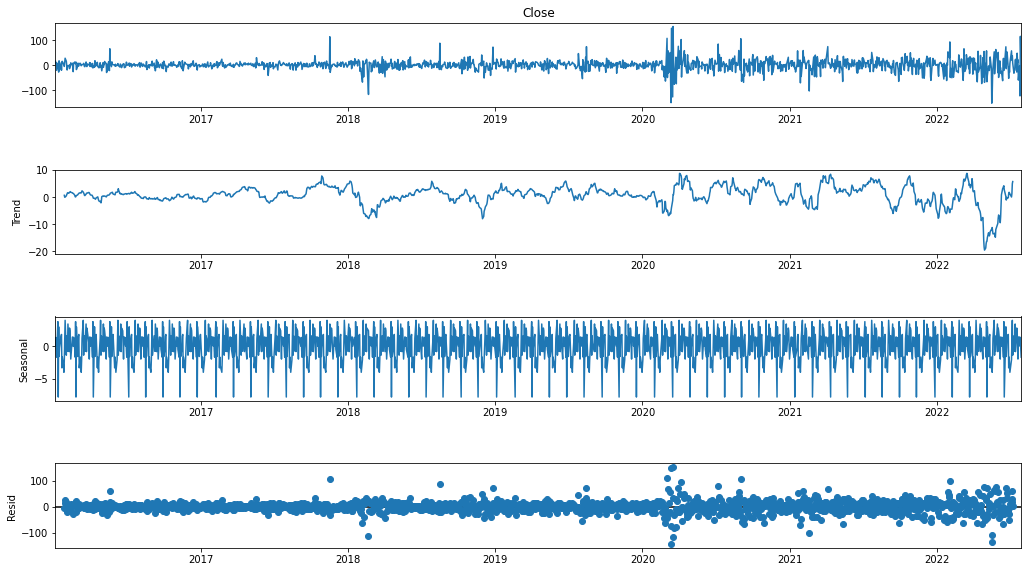

In [18]:
result = seasonal_decompose(transformed_train.Close, model='additive', period = 30)
fig = plt.figure()  
fig = result.plot()
fig.set_size_inches(16, 9)


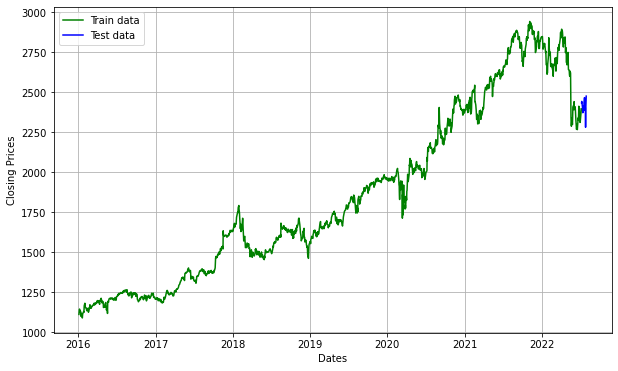

In [19]:
closingPrice = train.filter(['Date', 'Close'], axis = 1)
# splitting data into 99% training and 1% testing
train_data, test_data = closingPrice[:int(len(closingPrice)*0.99)], closingPrice[int(len(closingPrice)*0.99):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data.Close, 'green', label='Train data')
plt.plot(test_data.Close, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14752.538, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14745.985, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14746.363, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14752.646, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14747.289, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14747.439, Time=0.70 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14749.292, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=14746.409, Time=0.07 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.974 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1638
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -7369.993
Date:                Sun, 16 Oct 2022   AIC                          14745.985
Time:                       

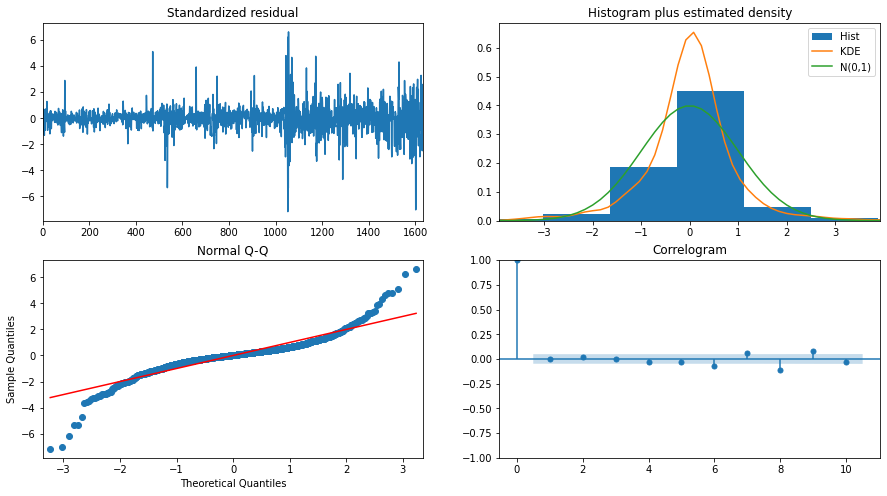

In [20]:
# finding best ARIMA parameters for the dataset
model_autoARIMA = auto_arima(train_data.Close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Best ARIMA model: SARIMAX(1,1,0)

In [21]:
model = ARIMA(train_data.Close, order = (1,1,0))  
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1638
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7371.204
Date:                Sun, 16 Oct 2022   AIC                          14746.409
Time:                        16:42:52   BIC                          14757.210
Sample:                             0   HQIC                         14750.415
                               - 1638                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0709      0.010     -6.926      0.000      -0.091      -0.051
sigma2       477.2979      7.057     67.633      0.000     463.466     491.130
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [22]:
# forecasting future values for testing portion of the dataset:
fc = fitted.forecast(len(test_data), alpha=0.05)  # 95% conf
conf = fitted.conf_int()
fc

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


1638    2394.083745
1639    2394.184798
1640    2394.177639
1641    2394.178146
1642    2394.178110
1643    2394.178113
1644    2394.178112
1645    2394.178112
1646    2394.178112
1647    2394.178112
1648    2394.178112
1649    2394.178112
1650    2394.178112
1651    2394.178112
1652    2394.178112
1653    2394.178112
1654    2394.178112
Name: predicted_mean, dtype: float64

In [23]:
# report performance
mse = mean_squared_error(test_data.Close, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data.Close, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data.Close, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data.Close)/np.abs(test_data.Close))
print('MAPE: '+str(mape))

MSE: 2089.2985447182155
MAE: 34.08125879550404
RMSE: 45.708845366276925
MAPE: nan


/opt/conda/lib/python3.7/site-packages/pandas/core/indexes/base.py:4024: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects
  join_index = self.union(other)


In [24]:
# ljung-box test to check for overfit
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(fitted.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,5.437557,0.860101


The p-value is higher than the significance level of 0.05<br>
Hence null hypothesis is significant and is not rejected.<br>
The model does not show lack of fit.

In [25]:
# forecasting future values for given values of test.csv
fc = fitted.forecast(35, alpha = 0.05)
test.head()
test.insert(4, "Close", fc.to_numpy())
test.head()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


,Date,Open,High,Low,Close,Volume
0,2022-08-01,2455.71,2500.26,2447.87,2394.083745,24327600
1,2022-08-02,2466.68,2494.73,2447.99,2394.184798,19076300
2,2022-08-03,2473.29,2507.59,2449.39,2394.177639,27459700
3,2022-08-04,2475.98,2487.75,2419.88,2394.178146,23699600
4,2022-08-05,2414.66,2444.17,2409.01,2394.178110,18912400


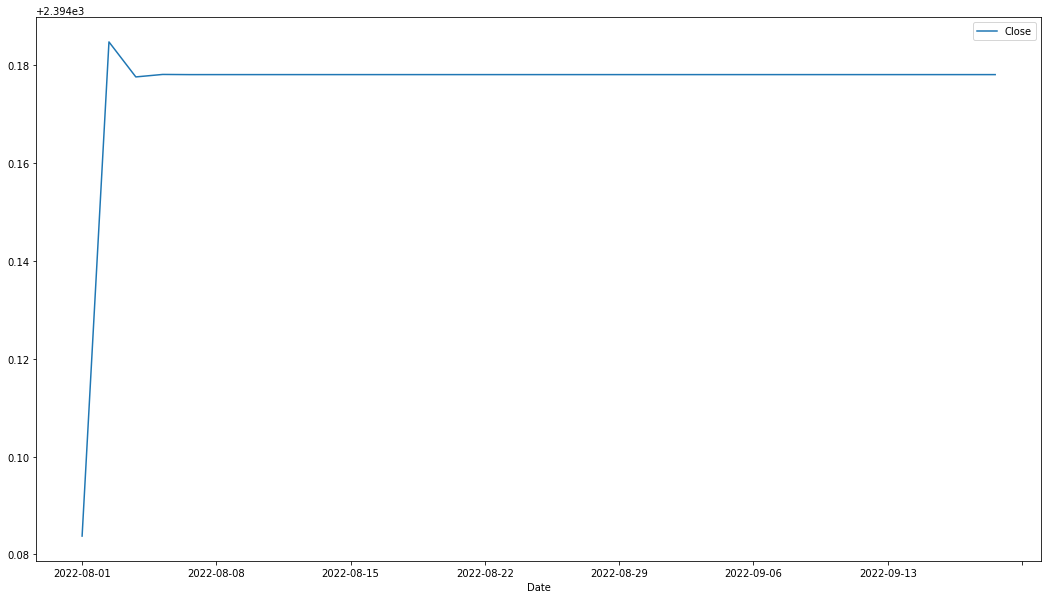

In [26]:
test.plot(x='Date', y='Close',figsize=(18,10));

In [27]:
# output required columns into submission.csv file
output = test.filter(['Date','Close'], axis = 1)
output.to_csv("submission.csv", index = False)